# Confounder accounted local effects

In [84]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from scipy.stats import spearmanr, pearsonr

import warnings
warnings.filterwarnings('ignore')
#warnings.resetwarnings()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Static data
counties, counties_date = load_counties()

In [5]:
deaths_df = get_cum_deaths_dataframe(n_days=28, onset_threshold=3, ma_width=7, time_series=True)
days = [d for d in deaths_df.columns if d[:4] == 'day_']

In [37]:
ddf = deaths_df.copy()
ddf = ddf.merge(counties[counties.columns.difference(ddf.columns).to_list() + ['FIPS']], on='FIPS')

## Edits
ddf = ddf.rename({
    'Density per square mile of land area - Population': 'POP Density',
    'Density per square mile of land area - Housing units': 'Housing Density',
}, axis=1)

## Normalized Mobility
ddf['OD_at_onset_normalized'] = ddf['OD_at_onset'] / ddf['OD_baseline']
ddf['OD_2wk_before_onset_normalized'] = ddf['OD_2wk_before_onset'] / ddf['OD_baseline']
ddf['OD_2wk_after_onset_normalized'] = ddf['OD_2wk_after_onset'] / ddf['OD_baseline']

## Black, african, hispanic, native american population
ddf['BAHN'] = ddf[['H_FEMALE', 'H_MALE', 'BA_FEMALE', 'BA_MALE', 'IA_MALE', 'IA_FEMALE']].sum(axis=1)

pop_vars = [
    'day_28',
    'Beds',
    'HospCt',
    'Total_age65plus',
    'POVALL_2018',
    'BAHN',
    'BA_MALE',
]
ddf[[l + '_normalized' for l in pop_vars]] = ddf[pop_vars].div(ddf['POP_ESTIMATE_2018'], axis=0)

## Normalize others
log_vars = [
    'day_28_normalized',
    'day_28',
    'OD_at_onset',
    'OD_baseline',
    'POP_ESTIMATE_2018',
    'POP Density',
    'Housing Density',
    'BAHN',
    'BA_MALE_normalized',
    'HospCt_normalized',
    'Beds_normalized'
]
## Compensate for 0 being a possible value
ddf[[l + ' (log)' for l in log_vars]] = ddf[log_vars].transform('log')


##
UPPER_CUTOFF = np.inf
LOWER_CUTOFF = 4

ddf = ddf[ddf[days[-1]] >= LOWER_CUTOFF]
ddf = ddf[ddf[days[-1]] <= UPPER_CUTOFF]

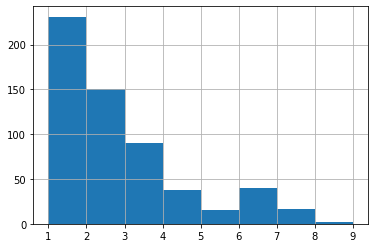

In [38]:
ddf['Rural-urban_Continuum Code_2013'].hist(bins=[1,2,3,4,5,6,7,8,9])

## All RUCCS

In [142]:
strat_df = ddf.copy()#[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

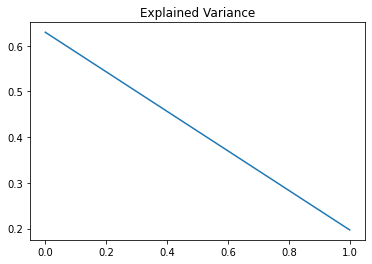

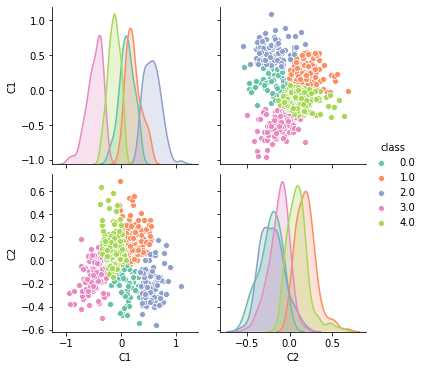

In [146]:
#vars = ['POP_ESTIMATE_2018 (log)', 'OD_baseline (log)']
vars = [
    'OD_baseline (log)',
    'OD_at_onset_normalized',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
    'onset_relative',
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
]
X = strat_df[vars].values.copy()
XX = X - X.min(axis=0)[None,:]
XX /= XX.max(axis=0)[None,:]
pca = PCA(n_components=2, svd_solver='full')
XXX = pca.fit_transform(XX)

clustering = KMeans(n_clusters=5, random_state=0).fit(XXX)
#clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='euclidean').fit(XX)
strat_df['strat_class'] = clustering.labels_

plt.plot(np.arange(XXX.shape[1]), pca.explained_variance_ratio_); plt.title('Explained Variance')

g = sns.pairplot(
    vars=['C1','C2'],
    data=pd.DataFrame(data=np.hstack((XXX, clustering.labels_[:,None])),columns=['C1','C2','class']),
    hue='class',
    palette="Set2",
)

plt.show()

### Investigating confounder effects

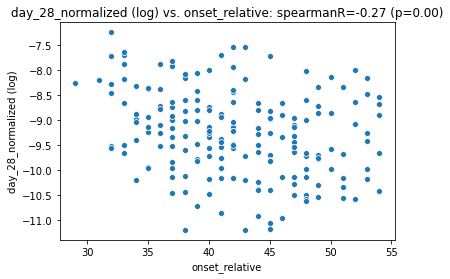

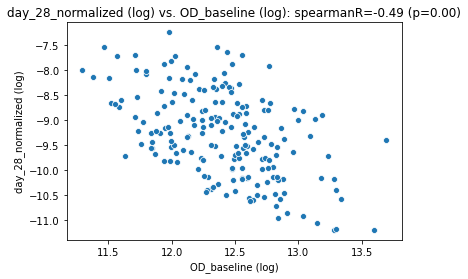

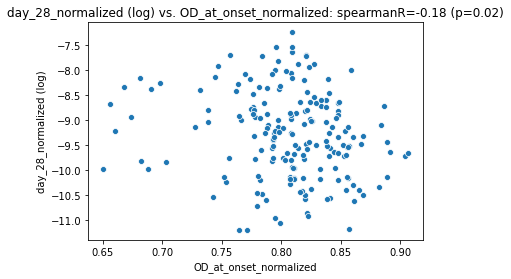

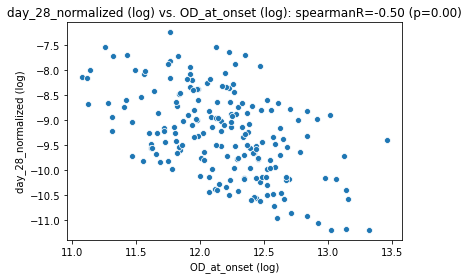

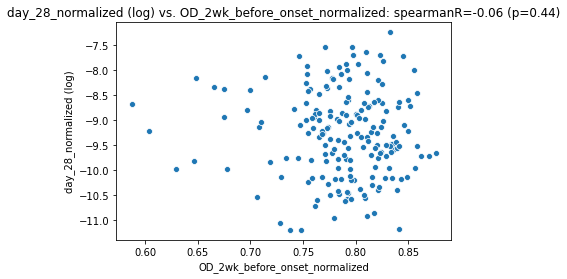

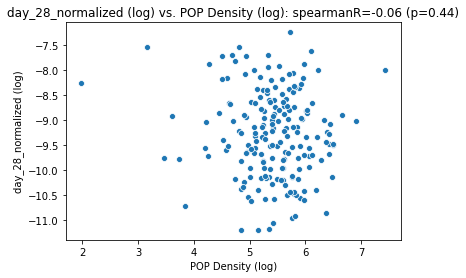

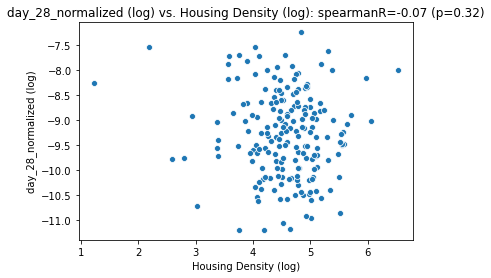

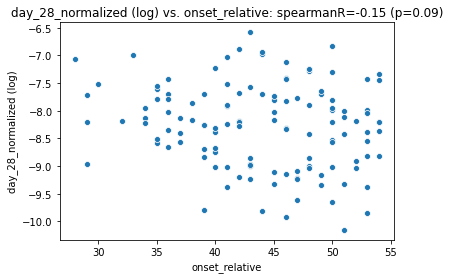

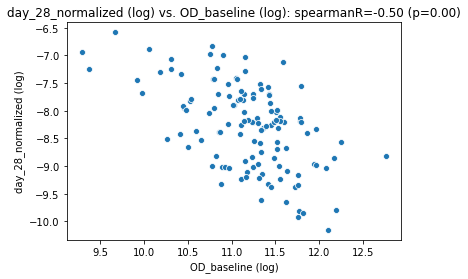

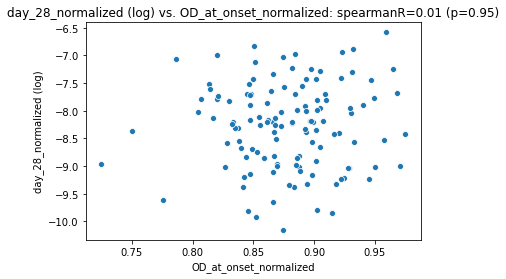

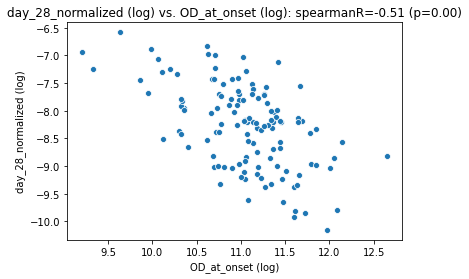

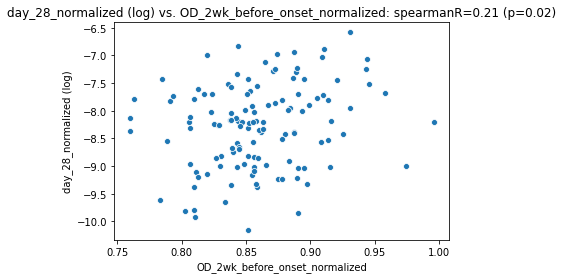

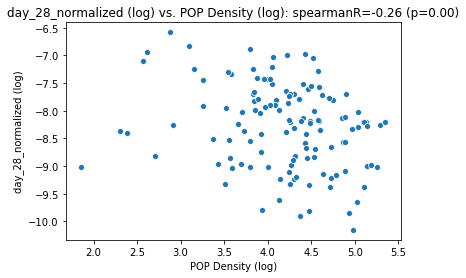

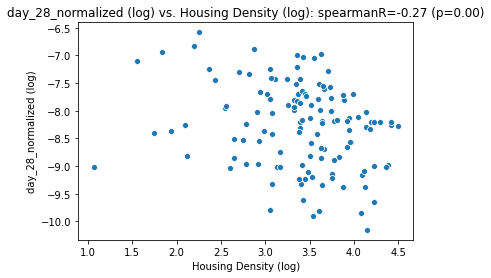

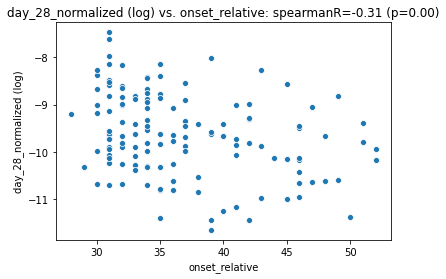

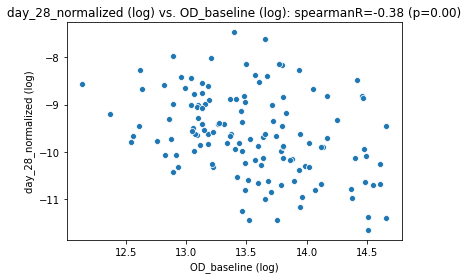

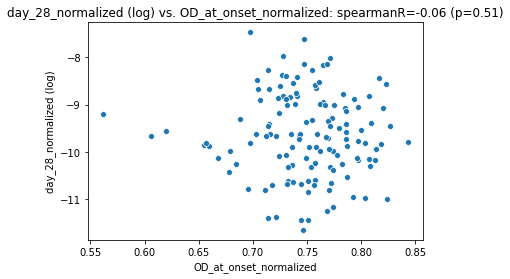

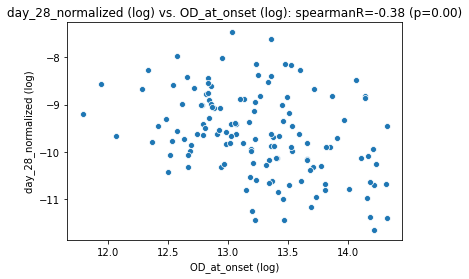

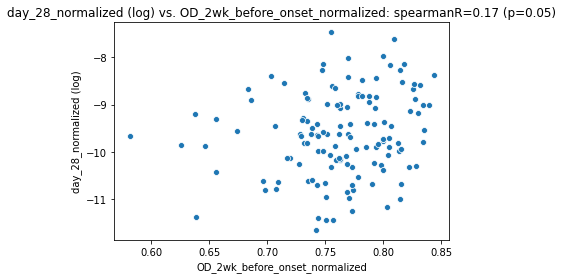

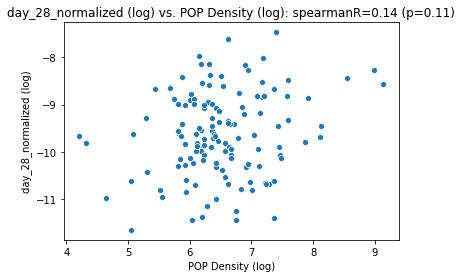

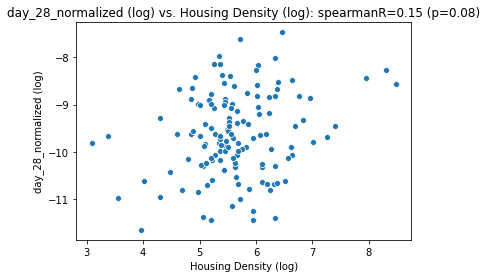

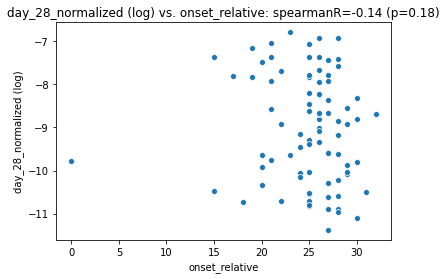

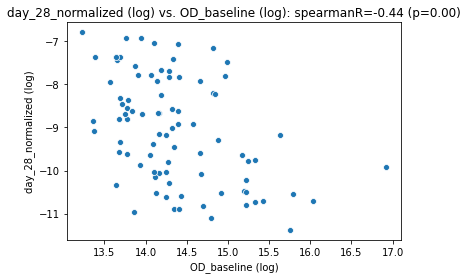

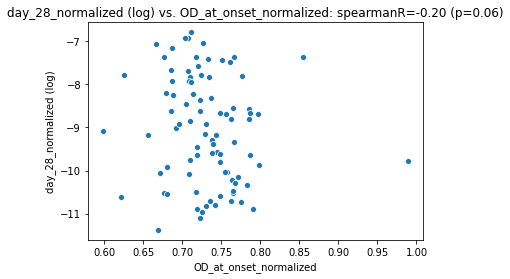

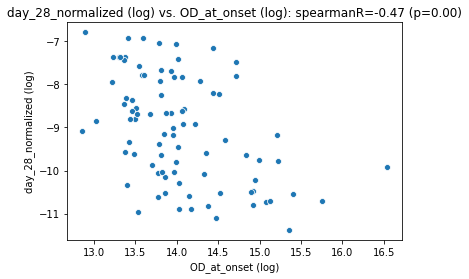

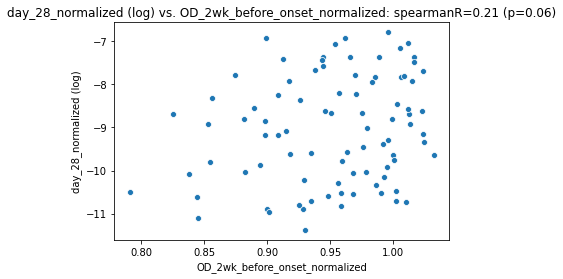

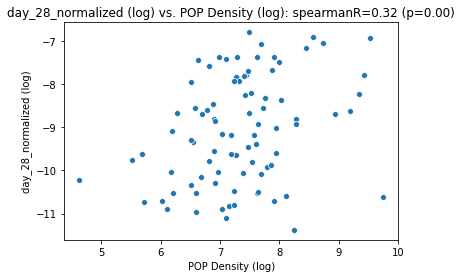

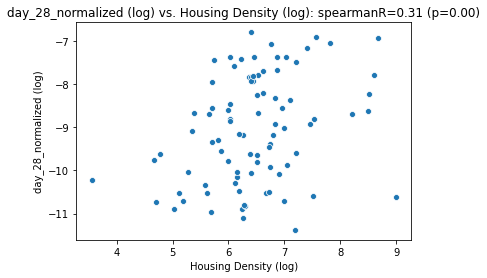

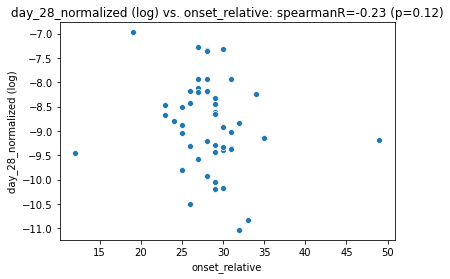

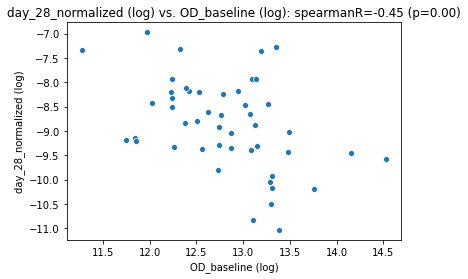

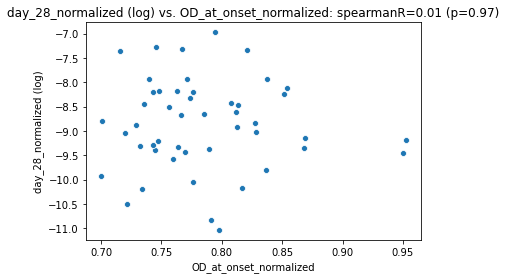

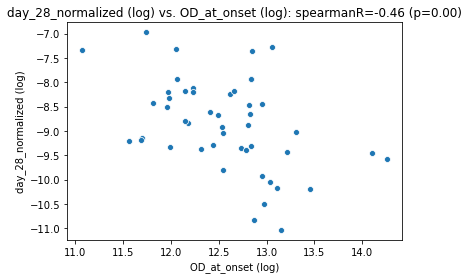

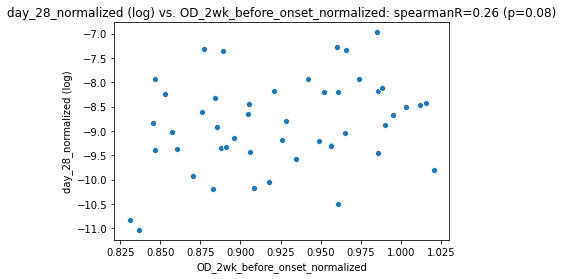

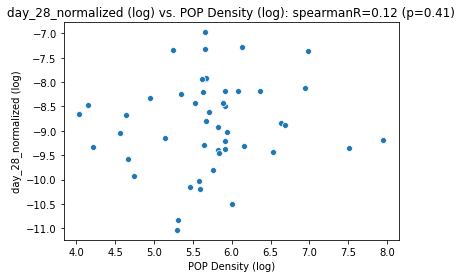

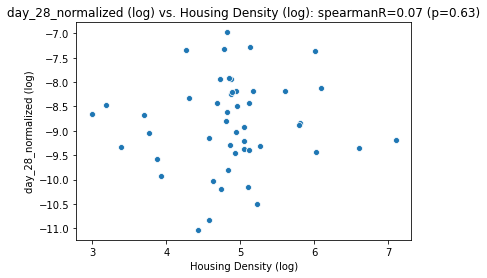

In [147]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
#     'POP_ESTIMATE_2018 (log)',# s,
#     'Beds_normalized',# s,
#     'HospCt_normalized',# s,
#     'Total_age65plus_normalized',# s,
#     'POVALL_2018_normalized',# s
#     'BAHN_normalized',# s
]
for strat_class in strat_df['strat_class'].unique():
    data = strat_df[strat_df['strat_class'] == strat_class]
    y = 'day_28_normalized (log)'
    for x in predictor_vars:
        fig,ax = plt.subplots()
        ax = sns.scatterplot(
            x=x,
            y=y,
            data=data,
            ax=ax
        )
        r,p = spearmanr(
            data[x],
            data[y]
        )
        ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

## Local Points

In [11]:
from sklearn.metrics import pairwise_distances
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import TweedieRegressor, LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import statsmodels.api as sm

In [12]:
X_dists = pairwise_distances(XXX[:,:2])

In [13]:
X0_idx = 39 ## Close to center of cluster
row = X_dists[X0_idx]
row /= np.max(row)

In [14]:
predictor_vars = [
#     'onset_relative',# s
#     'OD_baseline (log)',# s,
#     'OD_at_onset_normalized',# s,
#     'OD_at_onset (log)',
#     'OD_2wk_before_onset_normalized',# s,
#    'POP Density (log)',# s,
#    'Housing Density (log)',# s,
#     'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
target_var = 'day_28_normalized'

In [20]:
nn_lens = []
r2s = []
epsilons = np.arange(0.05,0.15,0.005)
for epsilon in epsilons:
    nn = np.where(row < epsilon)[0]

    X = strat_df[predictor_vars].copy().to_numpy()[nn]
    y = strat_df[target_var].copy().to_numpy()[nn]
    
    scaler = MinMaxScaler()
    XX = scaler.fit_transform(X)

    glm = sm.GLM(y, sm.add_constant(XX), family=sm.families.Gaussian(sm.families.links.log))
    glm = glm.fit()
    print(glm.summary())
    print(pd.DataFrame(np.vstack((glm.pvalues[1:][None,:],glm.params[1:][None,:])), columns=predictor_vars).rename(index={0:'pvalues', 1:'coef'}))
    break
    r2s.append(r2_score(y, glm.predict(sm.add_constant(XX))))
    nn_lens.append(len(nn))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   11
Model:                            GLM   Df Residuals:                        5
Model Family:                Gaussian   Df Model:                            5
Link Function:                    log   Scale:                      1.0752e-09
Method:                          IRLS   Log-Likelihood:                 100.97
Date:                Thu, 25 Jun 2020   Deviance:                   5.3762e-09
Time:                        22:52:51   Pearson chi2:                 5.38e-09
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.1170      0.669    -15.133      0.0

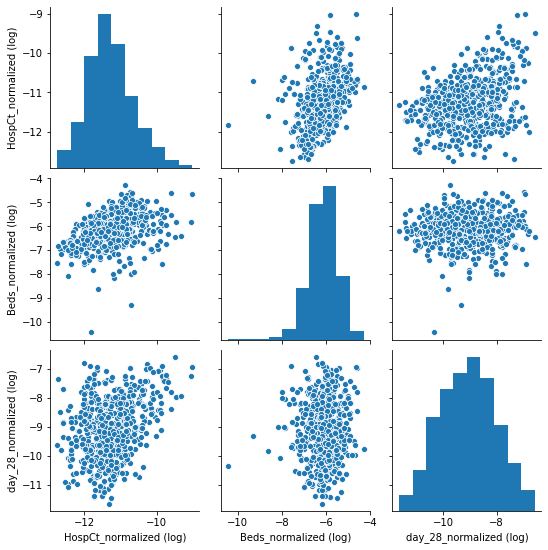

In [141]:
sns.pairplot(
    vars = ['HospCt_normalized (log)','Beds_normalized (log)','day_28_normalized (log)'],
    data=ddf
)

## Distance correlations (sort of)

In [24]:
X_ranks = np.asarray([
    np.argsort(x) for x in X_dists
])

In [165]:
def doubly_center(a):
    a = np.asarray(a)
    n = a.shape[0]
    ar = np.repeat(((a.mean(axis=0) * n) / (n)), n).reshape(-1, n).T
    ac = np.repeat(((a.T.mean(axis=0) * n) / (n)), n).reshape(-1, n)
    at = np.mean(a) * n * n / (n) / (n)
    a = a - ar - ac + at    
    return a

In [166]:
a = doubly_center(pairwise_distances(ddf['HospCt_normalized (log)'].copy()[:,None]))

In [170]:
hosps_dists = doubly_center(pairwise_distances(ddf['HospCt_normalized (log)'].copy()[:,None]))
beds_dists = doubly_center(pairwise_distances(ddf['Beds_normalized (log)'].copy()[:,None]))
deaths_dists = doubly_center(pairwise_distances(ddf['day_28_normalized (log)'].copy()[:,None]))

(array([ 18.,  45., 109., 149., 120.,  70.,  39.,  21.,   8.,   3.]),
 array([-12.74483245, -12.37193978, -11.99904711, -11.62615444,
        -11.25326177, -10.8803691 , -10.50747643, -10.13458376,
         -9.76169109,  -9.38879842,  -9.01590575]),
 <a list of 10 Patch objects>)

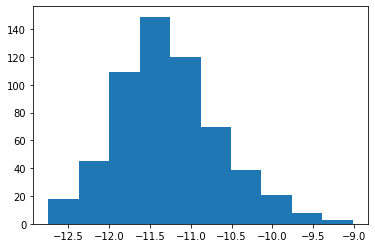

In [171]:
plt.hist(ddf['HospCt_normalized (log)'])

In [172]:
hd_prod = hosps_dists * deaths_dists
hh_prod = hosps_dists * hosps_dists
bd_prod = beds_dists * deaths_dists
bb_prod = beds_dists * beds_dists
dd_prod = deaths_dists * deaths_dists

In [173]:
dist_corrs_hosps = []
dist_corrs_beds = []
for i in range(X_ranks.shape[1]):
    indic = X_ranks <= i
    dist_corrs_hosps.append(
        np.sum(indic * hd_prod) / np.sqrt(np.sum(indic * hh_prod)) / np.sqrt(np.sum(indic * dd_prod))
    )
    dist_corrs_beds.append(
        np.sum(indic * bd_prod) / np.sqrt(np.sum(indic * bb_prod)) / np.sqrt(np.sum(indic * dd_prod))
    )

In [174]:
upper_dist_conf_hosps = []
lower_dist_conf_hosps = []
upper_dist_conf_beds = []
lower_dist_conf_beds = []
n_perms = 100
for i in range(X_ranks.shape[1]):
    perm_beds = []
    perm_hosps = []
    order = np.arange(X_ranks.shape[0])
    indic = X_ranks <= i
    for _ in range(n_perms):
        np.random.shuffle(order)
        deaths_dists_shuffled = deaths_dists.copy()[order][:, order]
        hd_prod = hosps_dists * deaths_dists_shuffled
        hh_prod = hosps_dists * hosps_dists
        bd_prod = beds_dists * deaths_dists_shuffled
        bb_prod = beds_dists * beds_dists
        dd_prod = deaths_dists_shuffled * deaths_dists_shuffled
        
        
        perm_hosps.append(
            np.sum(indic * hd_prod) / np.sqrt(np.sum(indic * hh_prod)) / np.sqrt(np.sum(indic * dd_prod))
        )
        perm_beds.append(
            np.sum(indic * bd_prod) / np.sqrt(np.sum(indic * bb_prod)) / np.sqrt(np.sum(indic * dd_prod))
        )
    perm_beds = np.sort(perm_beds)
    perm_hosps = np.sort(perm_hosps)
    upper_dist_conf_hosps.append(perm_hosps[94])
    lower_dist_conf_hosps.append(perm_hosps[4])
    upper_dist_conf_beds.append(perm_beds[94])
    lower_dist_conf_beds.append(perm_beds[4])

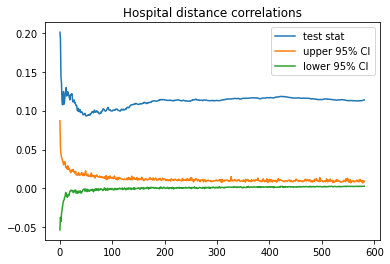

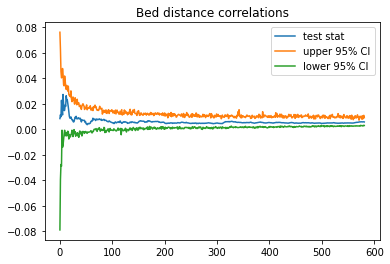

In [175]:
plt.plot(np.arange(X_ranks.shape[1]), dist_corrs_hosps, label='test stat')
plt.plot(np.arange(X_ranks.shape[1]), upper_dist_conf_hosps, label='upper 95% CI')
plt.plot(np.arange(X_ranks.shape[1]), lower_dist_conf_hosps, label='lower 95% CI')
plt.title('Hospital distance correlations')
plt.legend()
plt.show()

plt.plot(np.arange(X_ranks.shape[1]), dist_corrs_beds, label='test stat')
plt.plot(np.arange(X_ranks.shape[1]), upper_dist_conf_beds, label='upper 95% CI')
plt.plot(np.arange(X_ranks.shape[1]), lower_dist_conf_beds, label='lower 95% CI')
plt.title('Bed distance correlations')
plt.legend()
plt.show()

In [176]:
list(zip(np.arange(30), dist_corrs_hosps[:30]))

[(0, 0.20087975337001696),
 (1, 0.19226435296322472),
 (2, 0.1438361764546713),
 (3, 0.13530922814490845),
 (4, 0.11264080999539215),
 (5, 0.10739286093809995),
 (6, 0.11836245853566771),
 (7, 0.12462523436816177),
 (8, 0.10833860624547673),
 (9, 0.1129201746991852),
 (10, 0.12149898932388427),
 (11, 0.12123402219114945),
 (12, 0.12974171132689213),
 (13, 0.11879289200392101),
 (14, 0.12090836239754743),
 (15, 0.12423163324903265),
 (16, 0.12248756316906836),
 (17, 0.119858236114385),
 (18, 0.11674803184714595),
 (19, 0.1138481321605516),
 (20, 0.11982494854230033),
 (21, 0.12097106574244246),
 (22, 0.12050495217662087),
 (23, 0.12172272947671929),
 (24, 0.11383501035059873),
 (25, 0.11118187103886007),
 (26, 0.11267468965617632),
 (27, 0.1137193767785267),
 (28, 0.11013012350451351),
 (29, 0.11041205148288104)]

In [177]:
list(zip(np.arange(30), dist_corrs_beds[:30]))

[(0, 0.008456165073372515),
 (1, 0.011448064010099764),
 (2, 0.009879494049049),
 (3, 0.022765733310842397),
 (4, 0.016322827335263725),
 (5, 0.011300157372882915),
 (6, 0.02736835460193944),
 (7, 0.01990987510990532),
 (8, 0.014696766524988246),
 (9, 0.014920082491088069),
 (10, 0.01910730462528922),
 (11, 0.01803595637538575),
 (12, 0.026377281026870054),
 (13, 0.022956909267932986),
 (14, 0.02330215146428845),
 (15, 0.020355507702519943),
 (16, 0.0175309451906498),
 (17, 0.013574928591077203),
 (18, 0.010224529388642104),
 (19, 0.008808636350482114),
 (20, 0.008832719424729803),
 (21, 0.009751079025778105),
 (22, 0.008448283448387202),
 (23, 0.007453869060175561),
 (24, 0.007647874841021525),
 (25, 0.006271664097061313),
 (26, 0.005775895624096557),
 (27, 0.006108789849985236),
 (28, 0.007883586869616328),
 (29, 0.009556618364566763)]

In [178]:
hosps = ddf['HospCt_normalized (log)'].values
beds = ddf['Beds_normalized (log)'].values
deaths = ddf['day_28_normalized (log)'].values

nn = 15
print(f'HospCt nn={nn}')
hosp_corrs = []
hosp_max_dists = []
hosp_pvals = []

for row in X_dists:
    ranks = np.argsort(row)
    indic = ranks <= nn
    
    hosp_max_dists.append(np.max(row * indic))
    corr, pval = spearmanr(
        hosps[indic], deaths[indic]
    )
    hosp_corrs.append(corr)
    hosp_pvals.append(pval)
    
nn = 12
print(f'Beds nn={nn}')
bed_corrs = []
bed_max_dists = []
bed_pvals = []

for row in X_dists:
    ranks = np.argsort(row)
    indic = ranks <= nn
    
    bed_max_dists.append(np.max(row * indic))
    corr, pval = spearmanr(
        beds[indic], deaths[indic]
    )
    bed_corrs.append(corr)
    bed_pvals.append(pval)

HospCt nn=15
Beds nn=12


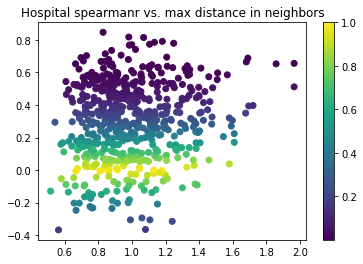

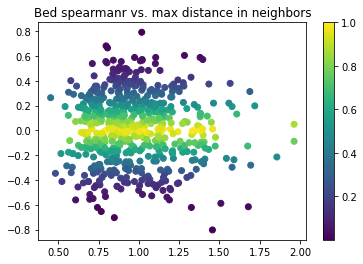

In [179]:
plt.scatter(hosp_max_dists, hosp_corrs, c = (np.asarray(hosp_pvals)))
plt.colorbar()
plt.title('Hospital spearmanr vs. max distance in neighbors')
plt.show()

plt.scatter(bed_max_dists, bed_corrs, c = bed_pvals)
plt.colorbar()
plt.title('Bed spearmanr vs. max distance in neighbors')
plt.show()

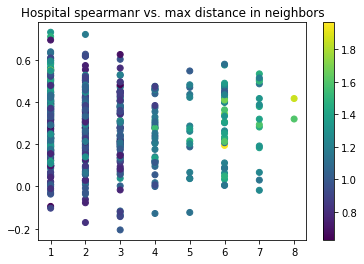

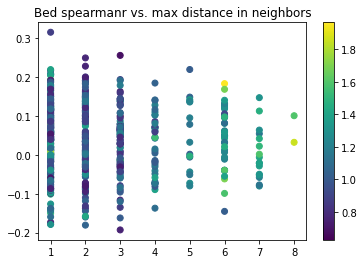

In [152]:
plt.scatter(ddf['Rural-urban_Continuum Code_2013'].values, hosp_corrs, c = hosp_max_dists)
plt.colorbar()
plt.title('Hospital spearmanr vs. max distance in neighbors')
plt.show()

plt.scatter(ddf['Rural-urban_Continuum Code_2013'].values, bed_corrs, c = hosp_max_dists)
plt.colorbar()
plt.title('Bed spearmanr vs. max distance in neighbors')
plt.show()